### Accounting for spatial heterogenity using spatial regimes model
This notebook demostrates how to fit spatial regimes model  using pysal's spreg library.

- A teaser example to look at spatial heterogneity
- Spatial regimes model: varying intercept
- Spatial regimes model: varying intercept + slopes
- Spatial regimes model + spatial error/lag model

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from libpysal.weights import Queen
from esda.moran import Moran
import spreg

### Read in the data

In [3]:
voting = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/voting_2020.csv')
voting[['median_income']] = voting[['median_income']]/10000

In [4]:
state_fips = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/us_state_fips.csv')

In [5]:
shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson")

In [6]:
#Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on = "county_id").merge(state_fips,left_on="state",right_on="state_fips")

#Remove DC since DC only has 1 "county" in its "state"
shp_voting = shp_voting[shp_voting.state != 11]

#Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='state')

Now lets take a look at the relationship between %Bach and %Dem vote at the national level.

In [7]:
#National level corr
from scipy.stats import pearsonr
pearsonr(shp_voting.new_pct_dem, shp_voting.pct_bach)

PearsonRResult(statistic=0.5276139176197585, pvalue=6.533277697586298e-222)

How about the correlation at the state level? For example what happens in 

In [8]:
tx = shp_voting[shp_voting.state_abbr == "TX"]
ca = shp_voting[shp_voting.state_abbr == "CA"]

PearsonRResult(statistic=0.23134670213619712, pvalue=0.00019965094959317964)


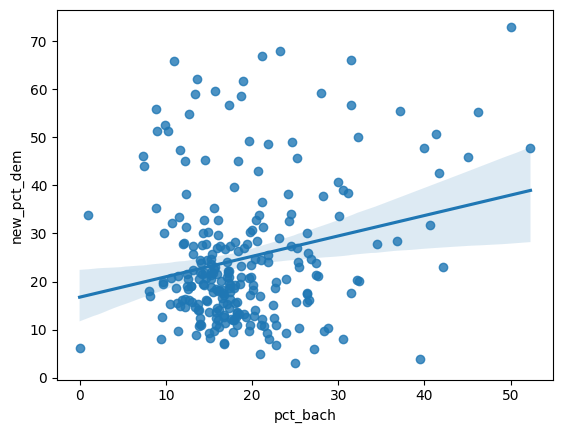

In [9]:
sns.regplot(data=tx,x='pct_bach', y='new_pct_dem')
print(pearsonr(tx.pct_bach, tx.new_pct_dem))

PearsonRResult(statistic=0.7606326644772614, pvalue=4.285244660552415e-12)


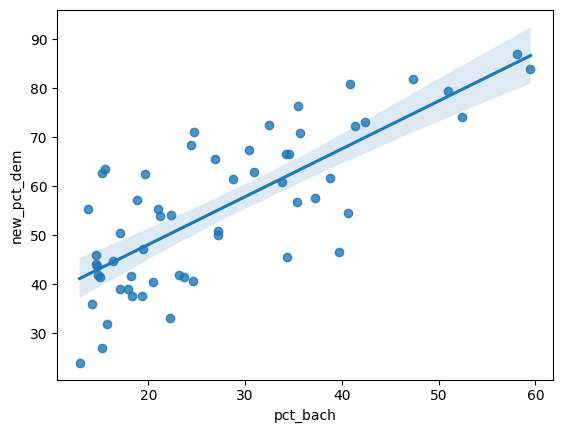

In [10]:
sns.regplot(data=ca,x='pct_bach', y='new_pct_dem')
print(pearsonr(ca.pct_bach, ca.new_pct_dem))

We find the relationship in these two states are quite different, what are about other states?

Text(0.5, 1.0, 'Correlation between Dem vote share vs. % Bach for each state')

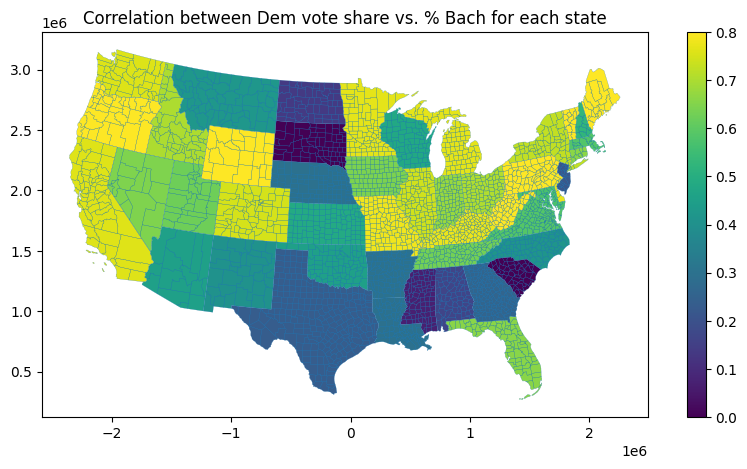

In [11]:
#State level corr
cor_dem_bach = shp_voting.groupby('state')[['new_pct_dem','pct_bach']].corr().iloc[0::2,-1].values

ax = state.plot(column=cor_dem_bach,legend=True,figsize=(10,5),vmin=0,vmax=0.8)
shp_voting.boundary.plot(ax=ax, linewidth=0.15)
plt.title("Correlation between Dem vote share vs. % Bach for each state")

Here is a map showing that what if we calculate the correlation coefficient for each individual state only using that state's counties. There seems to be a quite large spectrum. For SD and SC, education is not really correlated to the dem vote, whereas for states such as California, Maine, Wyoming, there is indeed a quite large positive association. 

### Spatial regimes model (fixed effects, varying intercept)

The idea of being "fixed" effect is that the parameter is a fixed value rather than a random variable from a certain distribution.

In [12]:
variable_names = ['sex_ratio', 'pct_black', 'pct_hisp',
                  'pct_bach', 'median_income','ln_pop_den']

y = shp_voting[['new_pct_dem']].values

X = shp_voting[variable_names].values

In [13]:
regimes_fe = spreg.OLS_Regimes(y, X, 
                            regimes = shp_voting.state_abbr.tolist(), #names of regimes
                            name_y='new_pct_dem',name_x=variable_names, 
                            
                            #If True, each regime will have a differrent error term.
                            regime_err_sep=False, 
                            
                            #This should be a list of booleans that which 
                            #predictor should have varying coefficients.
                            cols2regi=[False,False,False,False,False,False] 
                            )

print(regimes_fe.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : new_pct_dem                Number of Observations:        3102
Mean dependent var  :     33.7420                Number of Variables   :          53
S.D. dependent var  :     16.1917                Degrees of Freedom    :        3049
R-squared           :      0.8192
Adjusted R-squared  :      0.8161
Sum squared residual:      146964                F-statistic           :    265.7255
Sigma-square        :      48.201                Prob(F-statistic)     :           0
S.E. of regression  :       6.943                Log likelihood        :  -10385.522
Sigma-square ML     :      47.377                Akaike info criterion :   20877.045
S.E of regression ML:      6.8831                Schwarz criterion     :   21197.154

----------------------------------------

/Users/ziqili/anaconda3/lib/python3.11/site-packages/spreg/diagnostics.py:605: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


In addition to the "global_xx" coefficients, you also get a long list of state-level fixed effects estimated as intercept in the regime model. In OLS, you only have one intercept value, but in the regimes model, you have one intercept for each regime you have (i.e. state).

Let's try to map it out to see what are these values. This map tells us the spatial pattern of contextual effects which may  be related to culture, preference, history, policies, all of which are not included in our model (actually they are hard to measured by any data). By adding this fixed effect, we are trying to control for such heterogenity at the state level.



In [14]:
regimes_fe.betas[:47].reshape(-1)

array([ 2.33466996,  7.68975771, 23.10996897, 28.84003868, 19.9855495 ,
       24.95601209, 18.00397712,  6.95524714,  2.05913691, 23.57766388,
       12.42768002, 17.76918464, 16.48299356,  9.62602241, 12.72698042,
        0.92488939, 33.76880396, 16.25189996, 33.73565454, 23.59094343,
       26.32648111, 11.56929715,  1.8183401 , 20.90910416,  9.52190494,
       19.78688855, 10.16730169, 33.22370638, 17.24680093, 19.17604966,
       19.23513255, 21.91990771, 16.31783774,  6.78732104, 26.47105881,
       17.26685832,  5.26428429, 23.05340949,  8.04779461,  1.06605898,
       12.9411807 , 12.50739977, 43.53832655, 27.18985728, 29.13813969,
       14.10353273, 12.71361614])

Text(0.5, 1.0, 'State-level fixed effects')

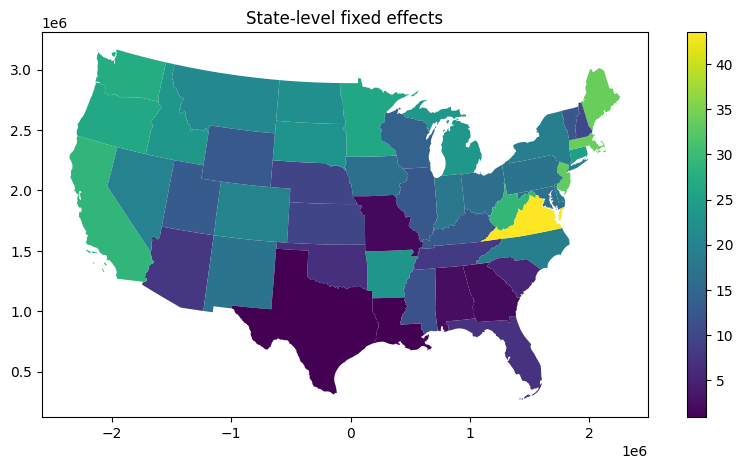

In [15]:
state.plot(column=regimes_fe.betas[:47].reshape(-1),legend=True,figsize=(10,5))

plt.title("State-level fixed effects")

The interpretation to the intercept is usaully related to un-measured/controlled state-level context, for example, state-lavel policy, regional culture/people's perception, etc.

In the second regimes_model, we can allow the coefficient of an independent vairable to vary at the state-level. 

In [16]:
regimes2 = spreg.OLS_Regimes(y, X, 
                            regimes= shp_voting.state_abbr.tolist(), #names of regimes
                            name_y='new_pct_dem',name_x=variable_names, 
                            regime_err_sep=False, #True for a full regimes, here is no
                            cols2regi=[False,False,True,False,False,False] 
                            #This should be a list of booleans that which 
                            #predictor should have varying coefficients.
                            )

print(regimes2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : new_pct_dem                Number of Observations:        3102
Mean dependent var  :     33.7420                Number of Variables   :          99
S.D. dependent var  :     16.1917                Degrees of Freedom    :        3003
R-squared           :      0.8333
Adjusted R-squared  :      0.8279
Sum squared residual:      135509                F-statistic           :    153.1996
Sigma-square        :      45.124                Prob(F-statistic)     :           0
S.E. of regression  :       6.717                Log likelihood        :  -10259.658
Sigma-square ML     :      43.684                Akaike info criterion :   20717.317
S.E of regression ML:      6.6094                Schwarz criterion     :   21315.257

----------------------------------------

We can see for each state we have two state-level effects, for for the intercept and one for the % hispanic. Then we would want to map these coefficinets out.

To get the coefficients, we may need to use a numpy trick, to get the every other value from the coefficients list. For example:

In [17]:
a = np.array([1,2,3,4,5,6,7,8,9,10])

In [18]:
a[1:10:2] # This returns numbers from index 1 to index 10 with an interval of 2.

array([ 2,  4,  6,  8, 10])

In [19]:
a[3:9:3] # This returns numbers from index 3 to index 9 with an interval of 3.

array([4, 7])

`regimes2.betas` returns all the coeffcients including state-level and global level coeffcients. Then we can use the trick to get the coefficeints for state-level %Hispanic and intercept, as well as the associated p-values `from regimes2.t_stat`.

In [20]:
state["intercept_fe"] = regimes2.betas[0:94:2]
state["intercept_p"] = np.array(regimes2.t_stat[0:94:2])[:,1]

state["pct_hisp_fe"] = regimes2.betas[1:94:2]
state["pct_hisp_p"] = np.array(regimes2.t_stat[1:94:2])[:,1]

Text(0.5, 1.0, 'Varying coefficints for intercept')

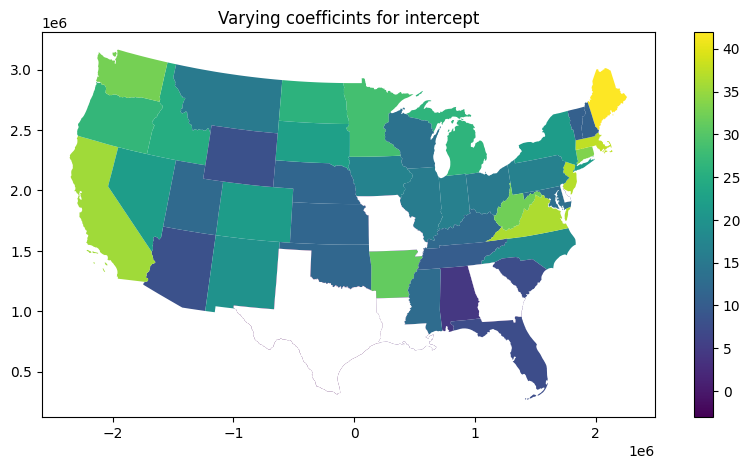

In [21]:
#norm = colors.BoundaryNorm([-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5],ncolors=256)

ax = state.plot(column="intercept_fe",legend=True,
           figsize=(10,5))

#masked out the insignificant estimates
state[state.intercept_p>=0.05].plot(ax = ax,color="white", aspect=1)

plt.title("Varying coefficints for intercept")

Text(0.5, 1.0, 'Varying coefficints for %Hispanic')

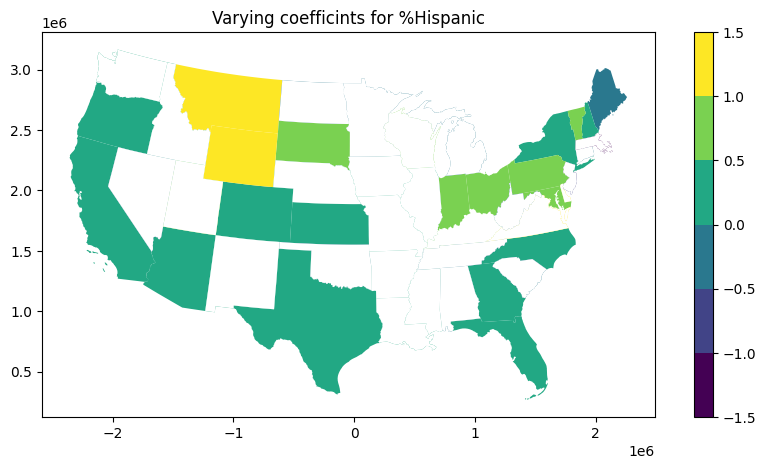

In [22]:
from matplotlib import colors
norm = colors.BoundaryNorm([-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5],ncolors=256)

ax = state.plot(column="pct_hisp_fe",legend=True,norm=norm,
           figsize=(10,5))

#masked out the insignificant estimates
state[state.pct_hisp_p>=0.05].plot(ax = ax,color="white", aspect=1)

plt.title("Varying coefficints for %Hispanic")

Next, let's examine residuals

Text(0.5, 1.0, 'Map of residuals of spatial regimes (intercept) model')

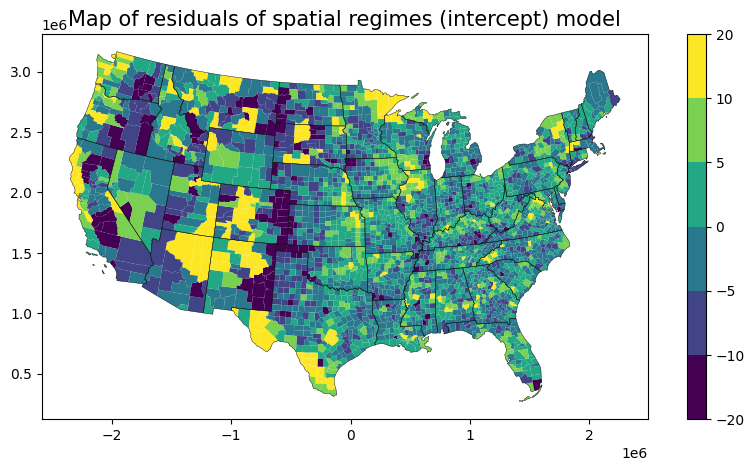

In [23]:
from matplotlib import colors

#For creating a discrete color classification
norm = colors.BoundaryNorm([-20, -10, -5, 0, 5, 10, 20],ncolors=256)

ax = shp_voting.plot(column=regimes_fe.u.reshape(-1),legend=True,
                     figsize=(10,5), norm=norm, linewidth=0.0)

state.boundary.plot(ax=ax, linewidth=0.3, edgecolor="black")

plt.title("Map of residuals of spatial regimes (intercept) model",fontsize=15)

In [24]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

('WARNING: ', 2631, ' is an island (no neighbors)')
('WARNING: ', 3079, ' is an island (no neighbors)')


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_54059/1693225803.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2631, 3079.
  warnings.warn(message)


In [25]:
regimes_fe_moran = Moran(regimes2.u, w)
regimes_fe_moran.I

0.3014978568178332

You will find the regimes model still produces correlated residuals. This would be a sign that we may need to add error or lag model to the regimes model to fix this issue.

### Spatial regimes + error model

In [26]:
regimes_sem = spreg.ML_Error_Regimes(y, X, w = w,
                                     regimes=shp_voting.state.tolist(),name_y='new_pct_dem',
                                     name_x=variable_names, regime_err_sep=False,
                                     cols2regi=[False,False,False,False,False,False])


print(regimes_sem.summary)

/Users/ziqili/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR - REGIMES (METHOD = full)
-------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : new_pct_dem                Number of Observations:        3102
Mean dependent var  :     33.7420                Number of Variables   :          53
S.D. dependent var  :     16.1917                Degrees of Freedom    :        3049
Pseudo R-squared    :      0.8107
Log likelihood      :  -9941.1798
Sigma-square ML     :     33.5874                Akaike info criterion :   19988.360
S.E of regression   :      5.7955                Schwarz criterion     :   20308.469

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          1_CONSTANT

Text(0.5, 1.0, 'Map of residuals in regimes + error model')

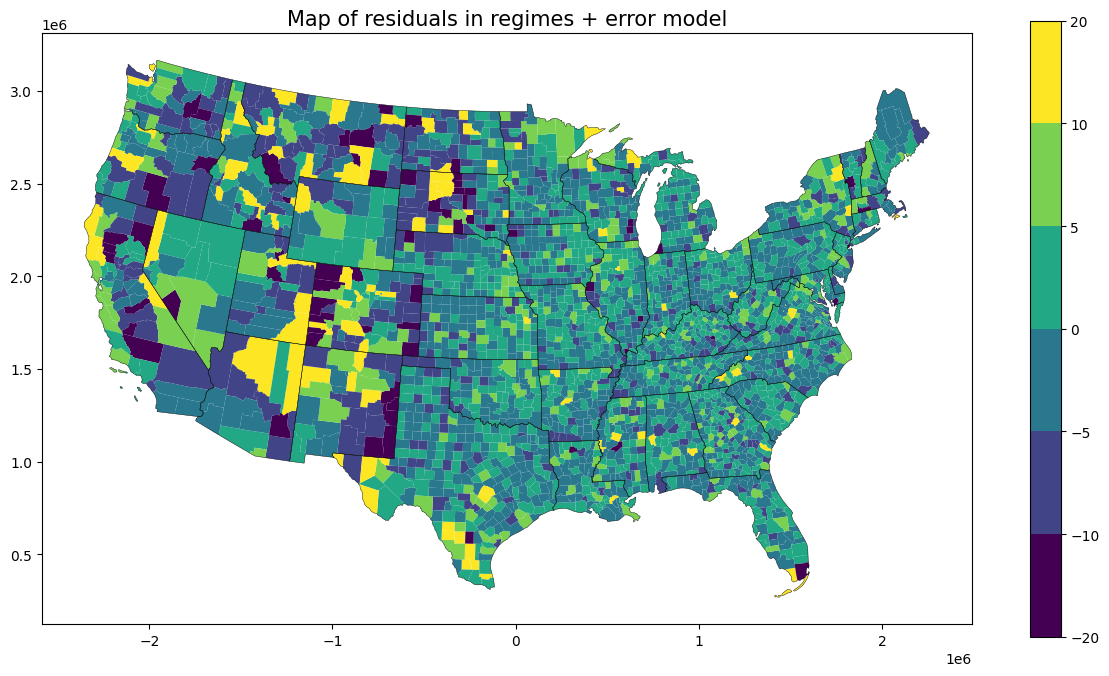

In [27]:
ax = shp_voting.plot(column=regimes_sem.e_filtered.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)

state.boundary.plot(ax=ax,linewidth=0.3,edgecolor="black")
plt.title("Map of residuals in regimes + error model",fontsize=15)

In [28]:
regimes_sem_moran = Moran(regimes_sem.e_filtered, w, permutations = 199) #199 permutations
print("Moran's I of the residuals:", regimes_sem_moran.I)

Moran's I of the residuals: -0.015141858418922715


We can conclude we are getting random residuals.

Now we find that by adding the error model to the regimes model, we are able to control for both spatial dependence and heterogenity.

In [29]:
help(spreg.ML_Lag_Regimes)

Help on class ML_Lag_Regimes in module spreg.ml_lag_regimes:

class ML_Lag_Regimes(spreg.ml_lag.BaseML_Lag, spreg.regimes.Regimes_Frame)
 |  ML_Lag_Regimes(y, x, regimes, w=None, constant_regi='many', cols2regi='all', method='full', epsilon=1e-07, slx_lags=0, regime_lag_sep=False, cores=False, vm=False, name_y=None, name_x=None, name_w=None, name_ds=None, name_regimes=None, latex=False)
 |  
 |  ML estimation of the spatial lag model with regimes (note no consistency 
 |  checks, diagnostics or constants added) :cite:`Anselin1988`.
 |  
 |  Parameters
 |  ----------
 |  y            : array
 |                 nx1 array for dependent variable
 |  x            : array
 |                 Two dimensional array with n rows and one column for each
 |                 independent (exogenous) variable, excluding the constant
 |  regimes      : list
 |                 List of n values with the mapping of each
 |                 observation to a regime. Assumed to be aligned with 'x'.
 |  constan

In [30]:
regimes_lag = spreg.ML_Lag_Regimes(y, X, w = w,
                                     regimes=shp_voting.state.tolist(),name_y='new_pct_dem',
                                     name_x=variable_names, regime_lag_sep=False,
                                     cols2regi=[False,False,False,False,False,False])


print(regimes_lag.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = full)
---------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : new_pct_dem                Number of Observations:        3102
Mean dependent var  :     33.7420                Number of Variables   :          54
S.D. dependent var  :     16.1917                Degrees of Freedom    :        3048
Pseudo R-squared    :      0.8510
Spatial Pseudo R-squared:  0.8163
Log likelihood      : -10122.2797
Sigma-square ML     :     39.0487                Akaike info criterion :   20352.559
S.E of regression   :      6.2489                Schwarz criterion     :   20678.709

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------

Add L-M tests in the regimes model output.

In [31]:
regimes3 = spreg.OLS_Regimes(y, X, w=w, spat_diag=True,
                            regimes= shp_voting.state_abbr.tolist(), #names of regimes
                            name_y='new_pct_dem',name_x=variable_names, 
                            regime_err_sep=False, #True for a full regimes, here is no
                            cols2regi=[False,False,True,False,False,False] 
                            #This should be a list of booleans that which 
                            #predictor should have varying coefficients.
                            )
print(regimes3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : new_pct_dem                Number of Observations:        3102
Mean dependent var  :     33.7420                Number of Variables   :          99
S.D. dependent var  :     16.1917                Degrees of Freedom    :        3003
R-squared           :      0.8333
Adjusted R-squared  :      0.8279
Sum squared residual:      135509                F-statistic           :    153.1996
Sigma-square        :      45.124                Prob(F-statistic)     :           0
S.E. of regression  :       6.717                Log likelihood        :  -10259.658
Sigma-square ML     :      43.684                Akaike info criterion :   20717.317
S.E of regression ML:      6.6094                Schwarz criterion     :   21315.257

----------------------------------------